In [3]:
#Here are the selected imports

import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from icrawler.builtin import GoogleImageCrawler
import matplotlib.image as mpimg
import os
from random import randrange
import cv2
import random
from PIL import Image
import json
from pathlib import Path
import torch
import matplotlib.pyplot as plt
plt.rcParams["savefig.bbox"] = 'tight'

from torchvision.transforms import v2
from torchvision.io import decode_image, read_file
from torchvision import tv_tensors
from matplotlib.patches import Rectangle
import torch.optim as optim


torch.manual_seed(1)



In [11]:
#Download Some Background image
directory = 'background'
if not os.path.exists(directory):
    os.makedirs(directory)

In [6]:

google_crawler = GoogleImageCrawler(
    parser_threads=2,
    downloader_threads=4,
    storage={'root_dir': 'background'}
)

for keyword in ['Las Vegas', 'Burj al arab', 'Seychelles', 'Azores', 'Canary islands', 'Budapest', 'Castle', 'Park', "Balaton", 'Porto']:
    google_crawler.crawl(
        keyword=keyword, max_num=20, file_idx_offset='auto')

2024-10-15 16:13:32,544 - INFO - icrawler.crawler - start crawling...
2024-10-15 16:13:32,547 - INFO - icrawler.crawler - starting 1 feeder threads...
2024-10-15 16:13:32,548 - INFO - feeder - thread feeder-001 exit
2024-10-15 16:13:32,550 - INFO - icrawler.crawler - starting 2 parser threads...
2024-10-15 16:13:32,553 - INFO - icrawler.crawler - starting 4 downloader threads...
2024-10-15 16:13:33,432 - INFO - parser - parsing result page https://www.google.com/search?q=Las+Vegas&ijn=0&start=0&tbs=&tbm=isch
Exception in thread parser-001:
Traceback (most recent call last):
  File "c:\Users\mihge\anaconda3\envs\ELTE\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "c:\Users\mihge\anaconda3\envs\ELTE\lib\site-packages\ipykernel\ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "c:\Users\mihge\anaconda3\envs\ELTE\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\mihge\anaconda3\envs\ELTE\l

KeyboardInterrupt: 

2024-10-15 16:13:37,559 - INFO - downloader - no more download task for thread downloader-003
2024-10-15 16:13:37,560 - INFO - downloader - no more download task for thread downloader-001
2024-10-15 16:13:37,560 - INFO - downloader - no more download task for thread downloader-004
2024-10-15 16:13:37,560 - INFO - downloader - no more download task for thread downloader-002
2024-10-15 16:13:37,560 - INFO - downloader - thread downloader-003 exit
2024-10-15 16:13:37,562 - INFO - downloader - thread downloader-001 exit
2024-10-15 16:13:37,563 - INFO - downloader - thread downloader-004 exit
2024-10-15 16:13:37,565 - INFO - downloader - thread downloader-002 exit


['000001.jpg', '000002.jpg', '000003.jpg', '000004.jpg', '000005.jpg', '000006.jpg', '000007.jpg', '000008.jpg', '000009.jpg', '000010.jpg', '000011.jpg', '000012.jpg', '000013.jpg', '000014.jpg', '000015.jpg', '000016.jpg', '000017.jpg', '000018.jpg', '000019.jpg', '000020.jpg', '000021.jpg', '000022.jpg', '000023.jpg', '000024.jpg', '000025.jpg', '000026.jpg', '000027.jpg', '000028.jpg', '000029.jpg', '000030.jpg', '000031.jpg', '000032.jpg', '000033.jpg', '000034.jpg', '000035.jpg', '000036.jpg', '000037.jpg', '000038.jpg', '000039.jpg', '000040.png', '000041.jpg', '000042.jpg', '000043.jpg', '000044.png', '000045.jpg', '000046.jpg', '000047.jpg', '000048.jpg', '000049.jpg', '000050.jpg', '000051.jpg', '000052.jpg', '000053.jpg', '000054.jpg', '000055.jpg', '000056.jpg', '000057.jpg', '000058.jpg', '000059.jpg', '000060.jpg', '000061.jpg', '000062.jpg', '000063.jpg', '000064.jpg', '000065.jpg', '000066.jpg', '000067.jpg', '000068.jpg', '000069.jpg', '000070.jpg', '000071.jpg', '0000

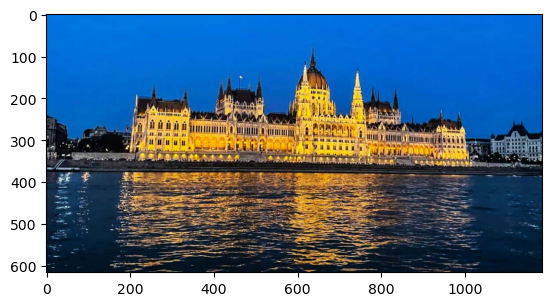

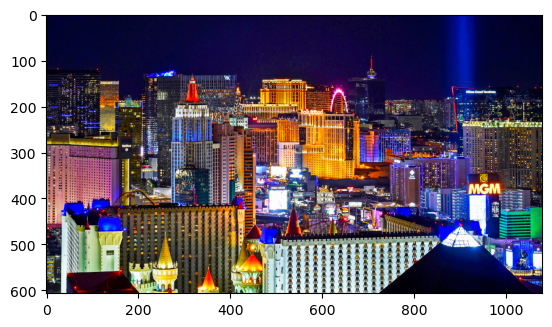

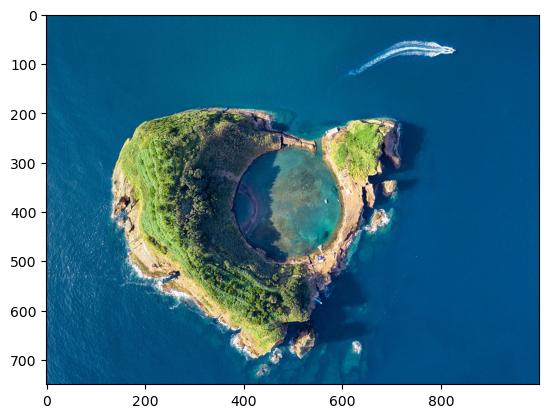

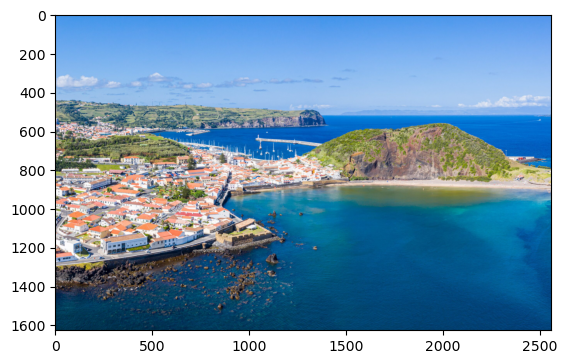

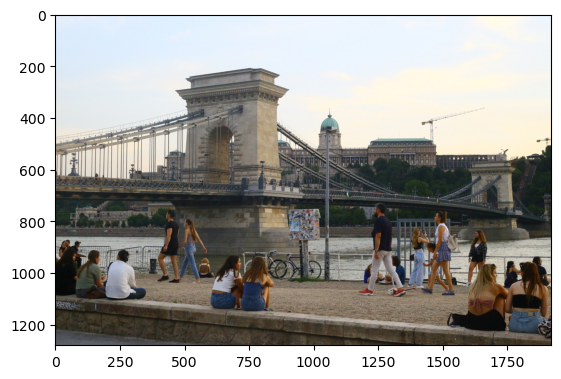

In [12]:

ImageNames = os.listdir(directory)
print(ImageNames)

def display_sample_images(directory: str, ImageName: str) -> None:
    image = mpimg.imread(f"{directory}\\{ImageName}")
    plt.figure()
    plt.imshow(image)

#This is going to show 5 random pictures
for i in range(5):
    randomNumber = randrange(len(ImageNames))
    display_sample_images(directory, ImageNames[randomNumber])

In [13]:

def GenerateIamgesandBoundingBoxes(ImageNames: list):
    #We create a folder for the New Images
    ObjBGPath = "OBJBG"
    if not os.path.exists(ObjBGPath):
        os.makedirs(ObjBGPath)
    OBJBGPic = "Images"
    if not os.path.exists(f"{ObjBGPath}\\{OBJBGPic}"):
        os.makedirs(f"{ObjBGPath}\\{OBJBGPic}")
    OBJBGBounding = "BoundingBox"
    if not os.path.exists(f"{ObjBGPath}\\{OBJBGBounding}"):
        os.makedirs(f"{ObjBGPath}\\{OBJBGBounding}")


    ObjectDirectory = 'Object'
    #Gather all the names of the objects
    ObjectNames = os.listdir(ObjectDirectory)

    #We suffle the list of background 
    random.shuffle(ImageNames)

    ObjectID = {
        ObjectNames[0] : 0,
        ObjectNames[1] : 1,
        ObjectNames[2] : 2
    }


    for i in ImageNames:
        #Open the images
        BackgroundImage = Image.open(f"{directory}\\{i}")
        
        #We choose a random Statue
        randomStatue = randrange(len(ObjectNames))
        StatueImage = Image.open(f"{ObjectDirectory}\\{ObjectNames[randomStatue]}")

        #We get the Image Size and scale them down randomly
        w, h = StatueImage.size
        bgw, bgh = BackgroundImage.size
        randomScaleNumber = round(random.uniform(0.3, 0.4), 2)
        StatueImage.thumbnail((w*randomScaleNumber, h*randomScaleNumber))

        #We resize the Image to be smaller and for every image to be the same size
        BackgroundImage = BackgroundImage.resize((256, 256))

        #We get the now Modified Statue and BG size
        bgw, bgh = BackgroundImage.size
        w, h = StatueImage.size

        #We define some random start points in the BG where we will insert the files
        randomPlaceonBGWidth = random.randint(0, bgw-w)
        randomPlaceonBGHeight = random.randint(0, bgh-h)


        #We Paste the images to the BG
        BackgroundImage.paste(StatueImage, (randomPlaceonBGWidth,randomPlaceonBGHeight), StatueImage.convert('RGBA'))
        class_id = ObjectID[ObjectNames[randomStatue]]
        #Create the Bounding box text
        # class_id = ObjectID[ObjectNames[randomStatue]]
        # x_center = (randomPlaceonBGWidth + w / 2) / bgw
        # y_center = (randomPlaceonBGHeight + h / 2) / bgh
        # width = w / bgw
        # height = h / bgh
        # BoundingBox = {
        #     "class_id": class_id,
        #     "x_center": x_center,
        #     "y_center": y_center,
        #     "width": width,
        #     "height": height
        # }

        #This is for Pytorch tv_tensors._bounding_boxis 'CXCYWH' format
        x_center = int(randomPlaceonBGWidth + (w / 2))
        y_center = int(randomPlaceonBGHeight + (h / 2))
        width = w
        height = h
        BoundingBox = {
            "class_id": class_id,
            "x_center": x_center,
            "y_center": y_center,
            "width": width,
            "height": height
        }

        

        open_cv_image = np.array(BackgroundImage)
        #To convert RGB to BGR
        try:
            open_cv_image = open_cv_image[:, :, ::-1].copy()

            with open(f"{ObjBGPath}\\{OBJBGBounding}\\{i[:-4]}.json", "w") as output:
                json.dump(BoundingBox, output, indent=4)
            cv2.imwrite(f"{ObjBGPath}\\{OBJBGPic}\\{i[:-4]}.jpg", open_cv_image)
        except:
            print(f"This picture is png: {i}")





In [14]:
GenerateIamgesandBoundingBoxes(ImageNames)

This picture is png: 000044.png
This picture is png: 000093.png
This picture is png: 000108.png
This picture is png: 000040.png


In [15]:
import sys
def GenerateTrainValTest(TypeData: str, numImages: int, PathofImages: list, PathofBB = list) -> None:


    PATHPic= 'OBJBG//Images'
    PATHBoundingBox = 'OBJBG//BoundingBox'

    #Where to output the images
    BasePath = "root//dataset//"
    if not os.path.exists(BasePath):
        os.makedirs(BasePath)
    
    if TypeData == 'train':
    #match TypeData:
        #case "train":
            OutPathIm = os.path.join(BasePath,"train//images")
            OutPathBB = os.path.join(BasePath,"train//labels")
            if not os.path.exists(OutPathIm):
                os.makedirs(OutPathIm)
            if not os.path.exists(OutPathBB):
                os.makedirs(OutPathBB)
            filename = "train"
    elif TypeData == "val":   
        #case "val":
            OutPathIm = os.path.join(BasePath,"val//images")
            OutPathBB = os.path.join(BasePath,"val//labels")
            if not os.path.exists(OutPathIm):
                os.makedirs(OutPathIm)
            if not os.path.exists(OutPathBB):
                os.makedirs(OutPathBB)
            filename = "val"
    elif TypeData == "test":    
        #case "test":
            OutPathIm = os.path.join(BasePath,"test//images")
            OutPathBB = os.path.join(BasePath,"test//labels")
            if not os.path.exists(OutPathIm):
                os.makedirs(OutPathIm)
            if not os.path.exists(OutPathBB):
                os.makedirs(OutPathBB)
            filename = "test"
        

    
    numberofimages = len(PathofImages)
    NumberAugIm = int(numImages/numberofimages)
    #We need a for loop to go through every image, and create copies of it with augmentation and save them
    ProcessImageNumber = 0
    for i in range(numberofimages):

        # Read the image file into a tensor of bytes
        useImage = os.path.join(PATHPic, PathofImages[i])
        useBB = os.path.join(PATHBoundingBox, PathofBB[i])

        #Load the given image
        img_path = Path(useImage)
        #Load the given bb
        with open(useBB, 'r') as file:
            BoundingBox = json.load(file)


        # Use read_file to load the image content
        img = decode_image(read_file(img_path))

        boxes = tv_tensors.BoundingBoxes(
            [[BoundingBox['x_center'], BoundingBox['y_center'], BoundingBox['width'], BoundingBox['height']]],  # Format: [center_x, center_y, width, height]
            format='CXCYWH', 
            canvas_size=(img.shape[1], img.shape[2])  # Canvas size is (height, width)
        )
        for j in range(NumberAugIm):
            transforms = v2.Compose([
                v2.ToDtype(torch.float32, scale=True),
                v2.RandomHorizontalFlip(p=0.5),
                v2.RandomAffine(random.randint(0, 360)),
                v2.RandomVerticalFlip(p=0.5),
                v2.GaussianBlur(random.randrange(1, 4, 2))
            ])

            out_img, out_boxes = transforms(img, boxes)
            # Convert out_img to a NumPy array

            # Manually convert boxes from CXCYWH to XYXY
            # out_boxes is still in CXCYWH format
            #boxes_tensor = out_boxes.tensor.numpy()  # Convert to numpy array for processing
            # out_boxes_xyxy = []

            for box in out_boxes:
                x_center, y_center, width, height = box
                
            ModifiedBoundingBox = {
                "class_id": BoundingBox["class_id"],
                "x_center":x_center.item(),
                "y_center": y_center.item(),
                "width": width.item(),
                "height": height.item()
            }

            out_img_np = out_img.permute(1, 2, 0).numpy()  # Change from (C, H, W) to (H, W, C)

            with open(f"{OutPathBB}\\{filename}{ProcessImageNumber:05d}.json", "w") as output:
                out_img_np = (out_img_np * 255).astype(np.uint8)
                out_img_np = cv2.cvtColor(out_img_np, cv2.COLOR_RGB2BGR)
                json.dump(ModifiedBoundingBox, output, indent=4)
            cv2.imwrite(f"{OutPathIm}\\{filename}{ProcessImageNumber:05d}.jpg", out_img_np)
            
            ProcessImageNumber += 1


            #     xmin = center_x - (width / 2)
            #     ymin = center_y - (height / 2)
            #     xmax = center_x + (width / 2)
            #     ymax = center_y + (height / 2)
            #     out_boxes_xyxy.append([xmin, ymin, xmax, ymax])

            # out_boxes_xyxy = np.array(out_boxes_xyxy)  # Convert list back to numpy array

            # # Plot the image
            # plt.figure(figsize=(8, 8))
            # plt.imshow(out_img_np)
            # ax = plt.gca()

            # # Draw bounding boxes
            # for box in out_boxes_xyxy:
            #     xmin, ymin, xmax, ymax = box
            #     width = xmax - xmin
            #     height = ymax - ymin
            #     rect = Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='r', facecolor='none')
            #     ax.add_patch(rect)

            # plt.axis('off')  # Turn off axis
            # plt.title("Image with Bounding Boxes")
            # plt.show()





Hogyan tovább:


Vasárnap:
Megcsináljuk a train, valid, test képeket és könyvtárformát, úgy ahogy a példában van mert az a legegyszerűbb. Elek

In [16]:
#Generate the Test, Train, Val datasets, with x, y, z images in each
GenImPath = "OBJBG\Images"
GenBBPath = "OBJBG\BoundingBox"
GeneratedImages = os.listdir(GenImPath)
GeneratedBB = os.listdir(GenBBPath)
TrainIm = GeneratedImages[:int(len(GeneratedImages)*0.7)]
TrainBB = GeneratedBB[:int(len(GeneratedBB)*0.7)]
ValIm = GeneratedImages[int(len(GeneratedImages)*0.7):int(len(GeneratedImages)*0.9)]
ValBB = GeneratedBB[int(len(GeneratedBB)*0.7):int(len(GeneratedBB)*0.9)]
TestIm = GeneratedImages[int(len(GeneratedImages)*0.9):]
TestBB = GeneratedBB[int(len(GeneratedBB)*0.9):]


GenerateTrainValTest(TypeData="train",numImages=2800, PathofImages=TrainIm, PathofBB=TrainBB)
GenerateTrainValTest(TypeData="val",numImages=800, PathofImages=ValIm, PathofBB=ValBB)


In [4]:
class ImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_dir = os.path.join(root_dir, 'images')
        self.label_dir = os.path.join(root_dir, 'labels')
        self.image_filenames = os.listdir(self.image_dir)
        self.transform = transform  # Default to ToTensor if no transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = self.image_filenames[idx]
        img_path = os.path.join(self.image_dir, img_name)
        
        # Load the image safely using PIL and convert to RGB
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            return None

        # Load the corresponding label (json file)
        label_name = img_name.replace('.jpg', '.json')  # Ensure this matches your label format
        label_path = os.path.join(self.label_dir, label_name)
        
        try:
            with open(label_path, 'r') as f:
                label_data = json.load(f)
        except Exception as e:
            print(f"Error loading label {label_path}: {e}")
            return None

        # Extract the bounding box information from the label
        try:
            class_id = label_data['class_id']
            x_center = label_data['x_center']
            y_center = label_data['y_center']
            width = label_data['width']
            height = label_data['height']

            # Convert bounding box from (x_center, y_center, width, height) to (x_min, y_min, x_max, y_max)
            bbox = [
                x_center - width / 2,  # x_min
                y_center - height / 2,  # y_min
                x_center + width / 2,  # x_max
                y_center + height / 2  # y_max
            ]
        except KeyError as e:
            print(f"Missing key in label {label_path}: {e}")
            return None

        # Apply any transformations on the image (if specified)
        if self.transform:
            image = self.transform(image)

        # Return image and label as a dictionary
        return {
            'image': image,
            'label': torch.tensor(class_id, dtype=torch.long),
            'bbox': torch.tensor(bbox, dtype=torch.float32)  # normalized bbox
        }
  



In [5]:
def visualize_dataset(dataset, numberofimages):
    ObjectDirectory = 'Object'  
    #Gather all the names of the objects
    ObjectNames = os.listdir(ObjectDirectory)

    #We suffle the list of background 
    random.shuffle(ImageNames)

    ObjectID = {
        0: ObjectNames[0][:-4],
        1: ObjectNames[1][:-4],
        2: ObjectNames[2][:-4]
    }

    

    for i in range(numberofimages):
        imagenumber = random.randint(0, len(dataset)-1)
        sample = dataset[imagenumber]
        image = sample['image']
        classid = sample['label'].item()
        classname = ObjectID[classid]

        image = image.permute(1, 2, 0).numpy()
        x_min, y_min, x_max, y_max = sample['bbox']
        bbox_width = x_max - x_min
        bbox_height = y_max - y_min

        fig, ax = plt.subplots(1)
        ax.imshow(image)
        rect = Rectangle((x_min, y_min), bbox_width, bbox_height, linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
        ax.add_patch(rect)
        plt.title(f"Sample: {imagenumber}, Class: {classname}")
        plt.show()


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


cpu


In [7]:
#New solution
import torch
import torch.nn as nn
import torch.optim as optim

class CustomObjectDetectionModel(nn.Module):
    def __init__(self, num_classes):
        super(CustomObjectDetectionModel, self).__init__()
        
        # Feature extraction layers (Simple CNN)
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output size: (32, H/2, W/2)

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output size: (64, H/4, W/4)

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Output size: (128, H/8, W/8)
        )
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),  # Global Average Pooling
            nn.Flatten(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )
        
        # Bounding box regression head
        self.bbox_regressor = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),  # Global Average Pooling
            nn.Flatten(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 4)  # Output: (x_min, y_min, x_max, y_max)
        )
    
    def forward(self, x):
        # Extract features
        features = self.features(x)
        
        # Get classification logits
        class_logits = self.classifier(features)
        
        # Get bounding box regression outputs
        bbox_regression = self.bbox_regressor(features)
        
        return class_logits, bbox_regression




In [8]:
import torch
import torch.optim as optim
from tqdm import tqdm

# Function to calculate accuracy
def calculate_accuracy(logits, labels):
    _, predicted_classes = torch.max(logits, 1)
    correct = (predicted_classes == labels).sum().item()
    accuracy = correct / labels.size(0)  # Correct predictions divided by the total number of labels
    return accuracy

# Define training function
def train_model(model, train_loader, val_loader, num_epochs=10, lr=0.001, device='cuda'):
    # Move the model to the correct device (GPU/CPU)
    model = model.to(device)
    
    # Define optimizer and loss functions
    optimizer = optim.Adam(model.parameters(), lr=lr)
    classification_loss_fn = nn.CrossEntropyLoss()
    bbox_loss_fn = nn.SmoothL1Loss()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        total_accuracy = 0.0

        # Iterate over the training data
        for batch in tqdm(train_loader):
            images = batch['image'].to(device)
            labels = batch['label'].to(device)
            bboxes = batch['bbox'].to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            class_logits, bbox_regression = model(images)

            # Calculate losses
            classification_loss = classification_loss_fn(class_logits, labels)
            bbox_loss = bbox_loss_fn(bbox_regression, bboxes)

            # Total loss is a weighted sum of classification and bbox regression loss
            loss = classification_loss + bbox_loss

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Calculate accuracy
            batch_accuracy = calculate_accuracy(class_logits, labels)
            total_accuracy += batch_accuracy

        avg_loss = running_loss / len(train_loader)
        avg_accuracy = total_accuracy / len(train_loader)

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {avg_accuracy*100:.2f}%")

        # Optionally, validate the model after each epoch
        validate_model(model, val_loader, device)

# Validation function (with accuracy)
def validate_model(model, val_loader, device):
    model.eval()
    total_loss = 0.0
    total_accuracy = 0.0
    with torch.no_grad():
        for batch in val_loader:
            images = batch['image'].to(device)
            labels = batch['label'].to(device)
            bboxes = batch['bbox'].to(device)

            # Forward pass
            class_logits, bbox_regression = model(images)

            # Calculate validation losses
            classification_loss = nn.CrossEntropyLoss()(class_logits, labels)
            bbox_loss = nn.SmoothL1Loss()(bbox_regression, bboxes)

            loss = classification_loss + bbox_loss
            total_loss += loss.item()

            # Calculate accuracy
            batch_accuracy = calculate_accuracy(class_logits, labels)
            total_accuracy += batch_accuracy

    avg_loss = total_loss / len(val_loader)
    avg_accuracy = total_accuracy / len(val_loader)
    print(f"Validation Loss: {avg_loss:.4f}, Validation Accuracy: {avg_accuracy*100:.2f}%")



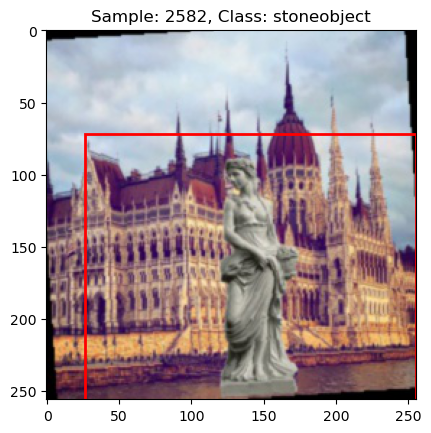

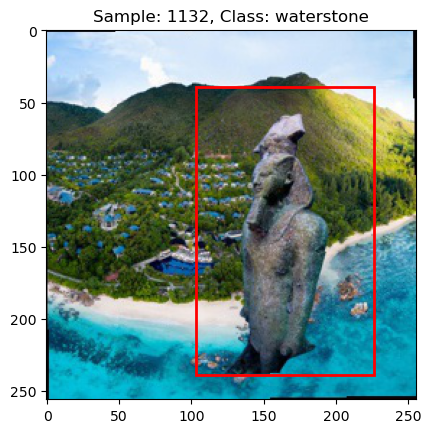

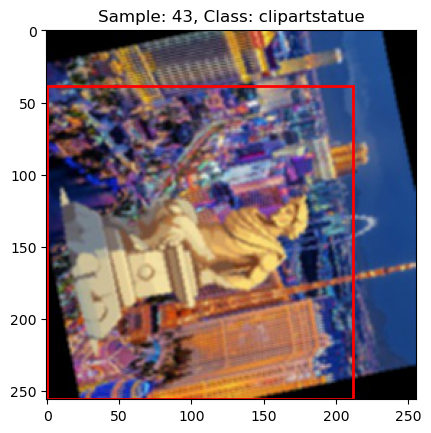

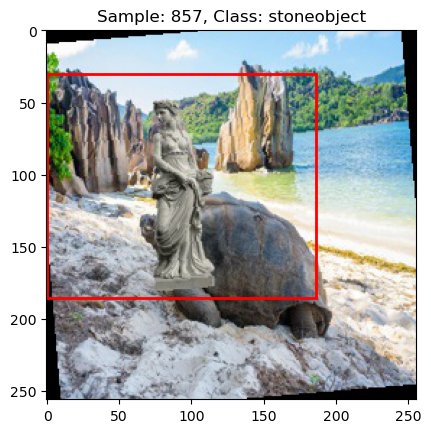

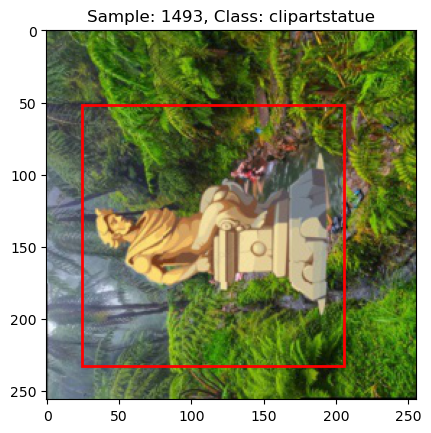

 19%|█▉        | 33/172 [00:28<02:01,  1.14it/s]


KeyboardInterrupt: 

In [13]:
# Assuming you've already defined your DataLoader
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to tensor
])

train_dataset = ImageDataset(root_dir='root\\dataset\\train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, pin_memory=False)

val_dataset = ImageDataset(root_dir='root\\dataset\\val', transform=transform)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, pin_memory=False)

# Instantiate the model
num_classes = 10  # Update based on your number of classes
model = CustomObjectDetectionModel(num_classes)
visualize_dataset(train_dataset, 5)


train_model(model, train_loader, val_loader, num_epochs=20, lr=0.001, device=device)
